# Opening a Japanese Restaurant in Boston: Choosing a Neighborhood

### This notebook will serve as a submission for the Coursera IBM Data Science Professional Certificate. 
Here, we will further explore and explain the process of choosing a neighborhood into which to open a new japanese restaurant.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import requests

from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

print('Libs Successfully Imported')

Libs Successfully Imported


#### Extract CSV Data for Boston Neighborhood Names, Zip Codes, and Latitudes and Longitudes
Sources: 
- Zip Codes with Latitude and Longitude [Simple Maps (US Census)](https://simplemaps.com/data/us-zips)
- Neighborhoods with Zip Codes: [Boston Archive](http://archive.boston.com/news/local/articles/2007/04/15/sixfigurezipcodes_city/)


In [2]:
# Webscrape the Zip Codes for each Neighborhood in Boston
zip_n = pd.read_html('http://archive.boston.com/news/local/articles/2007/04/15/sixfigurezipcodes_city/')[6]

#Clean the data
zip_n = zip_n[['Zip code', 'Community']]

#Check the data
zip_n.head()

,Zip code,Community
0,NaN,NaN
1,2101.0,Downtown Boston
2,2108.0,Beacon Hill
3,2109.0,Markets / Inner Harbor
4,2110.0,Financial District / Wharves


In [3]:
#Read in the Zip Code to Latitude and Longitude Data
zip_codes = pd.read_csv(r'C:\Users\penna\Downloads\uszips.csv')

#Clean the data to only keep zip codes, latitude, longitude
zip_codes = zip_codes[['zip','lat','lng']]

#Check the Data
zip_codes.head()

,zip,lat,lng
0,601,18.18005,-66.75218
1,602,18.36074,-67.17519
2,603,18.45440,-67.12201
3,606,18.16721,-66.93828
4,610,18.29032,-67.12244


In [4]:
# Merge and Clean the Data
community_coords = pd.merge(zip_n, zip_codes, left_on = 'Zip code', right_on = 'zip')
community_coords = community_coords.drop(columns = ['Zip code'])
community_coords = community_coords.drop_duplicates(subset = 'Community')
#Check the Data
community_coords.head()

,Community,zip,lat,lng
0,Beacon Hill,2108,42.35767,-71.06505
1,Markets / Inner Harbor,2109,42.36459,-71.05298
2,Financial District / Wharves,2110,42.35826,-71.05175
3,Chinatown / Tufts-New England Medical Center,2111,42.35007,-71.05911
4,North End,2113,42.36542,-71.05540


### Create a Map of Boston with its Neighborhoods

In [5]:
#Get a zip for Boston
address = 'Boston, MA'
geolocator = Nominatim(user_agent = 'boston_brah')
location = geolocator.geocode(address)
lat_map = location.latitude
long_map = location.longitude


#Make a map of Boston using Lat and Long from above
map_boston = folium.Map(location = [lat_map, long_map], zoom_start = 12)

for lat, lng, community in zip(community_coords['lat'], community_coords['lng'], community_coords['Community']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], radius = 5, popup = label, color = 'red', fill = True, fill_opacity = 0.5, parse_html = False).add_to(map_boston)

#Display the Map
map_boston
    

### Foursquare Data: Getting Frequency of Sushi Restaurant per Neighborhood

This will be the portion of the methodology where we will call the Foursquare API to understand the business composition of each neighborhood. We will choose restaurants that have a high frequency of restaurants, but a low frequency of Sushi Restaurants. 

### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = '20BM20LIAHJ4OZYIIV1ALUIO54MGDE42ACFIF0XJFXOI1V5Z' # your Foursquare ID
CLIENT_SECRET = 'DSNY4UFH1KMBKLUWJZUUQOVQ3TZMDQUMZPW2OB2T0NNH1QYN' # your Foursquare Secret
ACCESS_TOKEN = 'CFBMAFIS2LGDL0T2PS4OSVR0NQGAVDK3ZLHYTL2BIWOJ4DX4'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 20BM20LIAHJ4OZYIIV1ALUIO54MGDE42ACFIF0XJFXOI1V5Z
CLIENT_SECRET:DSNY4UFH1KMBKLUWJZUUQOVQ3TZMDQUMZPW2OB2T0NNH1QYN


### Get Nearby Venues
Here we will define a function "getNearbyVenues" to automatically extract venue data for our neighborhoods)

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
#Apply the Function to our Dataset
boston_venues = getNearbyVenues(community_coords['Community'],
                               community_coords['lat'],
                               community_coords['lng'])

In [9]:
#Check the data
boston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beacon Hill,42.35767,-71.06505,Boston Common,42.355487,-71.064882,Park
1,Beacon Hill,42.35767,-71.06505,Boston Athenaeum,42.357481,-71.061838,Library
2,Beacon Hill,42.35767,-71.06505,Yvonne's,42.355664,-71.061466,New American Restaurant
3,Beacon Hill,42.35767,-71.06505,The Freedom Trail,42.357314,-71.061038,Historic Site
4,Beacon Hill,42.35767,-71.06505,Sam LaGrassa's,42.356870,-71.059960,Sandwich Place


### Check how many values were returned for each neighborhood

In [10]:
boston_venues[['Neighborhood', 'Venue']].groupby('Neighborhood').count()

,Venue
Neighborhood,
Allston,100
Back Bay,100
Beacon Hill,100
Brighton,100
Brookline,100
Cambridge,100
Charlestown,100
Chinatown / Tufts-New England Medical Center,100
Dorchester / Codman Square,99


#### Check how many unique categories can be returned from all venues, and what they are

In [11]:
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))

There are 263 uniques categories.


### Analyze Each Neighborhood with One-Hot Encoding

In [12]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Beacon Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Beacon Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Beacon Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Beacon Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Beacon Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
boston_onehot.shape

(3017, 264)

### Group by Neighborhoods, taking the mean of the frequency of each category of occurrence

In [14]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allston,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.0,...,0.01,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0
1,Back Bay,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.04,0.0,...,0.00,0.0,0.01,0.02,0.0,0.0,0.0,0.00,0.0,0.0
2,Beacon Hill,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0
3,Brighton,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.01,0.0,...,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0
4,Brookline,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.02,0.0,...,0.01,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0


In [15]:
num_top_venues = 5

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
                 venue  freq
0          Pizza Place  0.06
1               Bakery  0.04
2  Fried Chicken Joint  0.03
3   Seafood Restaurant  0.03
4            Rock Club  0.03


----Back Bay----
                 venue  freq
0                 Park  0.05
1                Hotel  0.04
2       Clothing Store  0.04
3   Italian Restaurant  0.04
4  American Restaurant  0.04


----Beacon Hill----
                venue  freq
0         Coffee Shop  0.07
1                Park  0.07
2  Italian Restaurant  0.06
3  Seafood Restaurant  0.05
4              Bakery  0.05


----Brighton----
         venue  freq
0  Pizza Place  0.09
1          Bar  0.06
2          Gym  0.04
3  Coffee Shop  0.04
4         Café  0.04


----Brookline----
         venue  freq
0         Park  0.06
1         Café  0.05
2  Pizza Place  0.05
3  Coffee Shop  0.05
4          Gym  0.04


----Cambridge----
                venue  freq
0                Café  0.06
1  Italian Restaurant  0.05
2              Bakery  0.04
3   

### Putting this Output into new DataFrame
Analyzing the most common venue in every neighborhood in our dataframe.

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Pizza Place,Bakery,Grocery Store,Rock Club,Fried Chicken Joint,Bar,Seafood Restaurant,Sushi Restaurant,Gym,Mexican Restaurant
1,Back Bay,Park,Hotel,Italian Restaurant,Seafood Restaurant,Clothing Store,American Restaurant,Bakery,French Restaurant,Coffee Shop,Gym
2,Beacon Hill,Park,Coffee Shop,Italian Restaurant,Seafood Restaurant,Bakery,Hotel,Spa,Gourmet Shop,Gym / Fitness Center,Historic Site
3,Brighton,Pizza Place,Bar,Coffee Shop,Gym,Sushi Restaurant,Bakery,Café,Grocery Store,Rock Club,Shoe Store
4,Brookline,Park,Coffee Shop,Pizza Place,Café,Gym,Mexican Restaurant,Hotel,Sushi Restaurant,Italian Restaurant,Liquor Store


### Let's Isolate Sushi Restaurants
Analyze each neighborhood's frequency of Sushi Restaurants. 

In [18]:
#Get all Japanese and Sushi Restaurants 
sushi_restaurants = boston_venues.loc[boston_venues['Venue Category'] == 'Sushi Restaurant'].reset_index(drop=True)

#Check the Data
sushi_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beacon Hill,42.35767,-71.06505,O Ya,42.351502,-71.056763,Sushi Restaurant
1,Financial District / Wharves,42.35826,-71.05175,O Ya,42.351502,-71.056763,Sushi Restaurant
2,Chinatown / Tufts-New England Medical Center,42.35007,-71.05911,O Ya,42.351502,-71.056763,Sushi Restaurant
3,Back Bay,42.35062,-71.07564,Douzo,42.346855,-71.075733,Sushi Restaurant
4,South End,42.33820,-71.07074,Seiyo Sushi & Wine Shop,42.336972,-71.076376,Sushi Restaurant


In [19]:
#Group by Neighborhood
sushi_neighbor = sushi_restaurants[['Venue Category','Neighborhood']].groupby(['Neighborhood'], as_index = False).count().sort_values(by=['Venue Category'], ascending = False).reset_index(drop = True)
sushi_neighbor.columns = ['Neighborhood', 'Total # of Sushi Restaurants']
sushi_neighbor.head()

,Neighborhood,Total # of Sushi Restaurants
0,Brighton,4
1,Allston,3
2,Brookline,3
3,North Brighton / Cambridge,2
4,Roxbury,2


### Put all Sushi Restauranst on a Map
This will help us get an idea of where Sushi restaurants are most common.

In [35]:

#Make a map of Boston using Lat and Long from above

sushi_map = folium.Map(location = [lat_map, long_map], zoom_start = 12)

#add all Sushi Restaurants
for lat, lng, community in zip(sushi_restaurants['Venue Latitude'], sushi_restaurants['Venue Longitude'], sushi_restaurants['Venue Category']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], radius = 5, popup = label, color = 'red', fill = True, fill_opacity = 0.5, parse_html = False).add_to(sushi_map)

#Display the Map
sushi_map



### Select all Venues that Contain the word "Restaurant"
Check which restaurants have the highest frequency of restaurants.

In [21]:
#Isolate only venues that contain the string "Restaurant"
boston_restaurants = boston_venues[boston_venues['Venue Category'].str.contains('Restaurant')]

#Check the Data
boston_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Beacon Hill,42.35767,-71.06505,Yvonne's,42.355664,-71.061466,New American Restaurant
15,Beacon Hill,42.35767,-71.06505,Ma Maison,42.361095,-71.067915,French Restaurant
28,Beacon Hill,42.35767,-71.06505,The Oceanaire Seafood Room,42.359071,-71.059173,Seafood Restaurant
33,Beacon Hill,42.35767,-71.06505,Scampo at The Liberty Hotel,42.361937,-71.070513,Italian Restaurant
35,Beacon Hill,42.35767,-71.06505,Saus Restaurant,42.361076,-71.057054,Belgian Restaurant


In [22]:
#Find the Neighborhoods with the Highest Number of Restaurants
temp = boston_restaurants.groupby('Neighborhood', as_index = False).count()
res_count = temp[['Neighborhood', 'Venue']].sort_values('Venue', ascending = False).reset_index(drop=True)
res_count.columns = ['Neighborhood', 'Total # of Restaurants']
res_count.head()

,Neighborhood,Total # of Restaurants
0,Somerville,36
1,Roxbury Crossing,35
2,South Boston / Fort Point,34
3,South Boston,33
4,Roxbury,32


### Get the number of Restaurants and number of Sushi Restaurants in a Dataframe together

In [23]:
sushi_to_restaurants = pd.merge(sushi_neighbor, res_count, on = 'Neighborhood')
sushi_to_restaurants

,Neighborhood,Total # of Sushi Restaurants,Total # of Restaurants
0,Brighton,4,27
1,Allston,3,28
2,Brookline,3,23
3,North Brighton / Cambridge,2,28
4,Roxbury,2,32
5,South End,2,25
6,Back Bay,1,22
7,Beacon Hill,1,19
8,Chinatown / Tufts-New England Medical Center,1,19
9,Financial District / Wharves,1,25


### Get the Percentage of Restaurants that are Sushi Restaurants

In [24]:
#Create and Populate New Column
sushi_to_restaurants['Percentage of Sushi Restaurants (%)'] = (sushi_to_restaurants['Total # of Sushi Restaurants'] / sushi_to_restaurants['Total # of Restaurants'])*100

#sort by the percentage of Sushi Restaurants
sushi_to_restaurants.sort_values('Percentage of Sushi Restaurants (%)', ascending = False)

,Neighborhood,Total # of Sushi Restaurants,Total # of Restaurants,Percentage of Sushi Restaurants (%)
0,Brighton,4,27,14.814815
2,Brookline,3,23,13.043478
1,Allston,3,28,10.714286
5,South End,2,25,8.000000
3,North Brighton / Cambridge,2,28,7.142857
4,Roxbury,2,32,6.250000
7,Beacon Hill,1,19,5.263158
8,Chinatown / Tufts-New England Medical Center,1,19,5.263158
6,Back Bay,1,22,4.545455
10,Prudential,1,23,4.347826


### Visualize the Data
This will be achieved using matplotlib

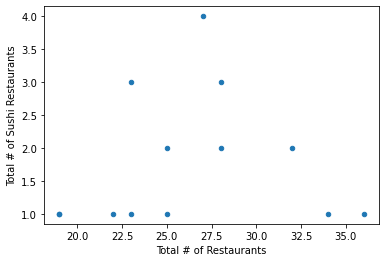

In [25]:
#Let's Visualize the Data
ax1 =  sushi_to_restaurants.plot.scatter('Total # of Restaurants', 'Total # of Sushi Restaurants')

### Let's attempt a Clustering Analysis on the Dataset
This will give us the final output of our report, a map of Boston with the most convenient neighborhoods clustered together.

In [26]:
# set number of clusters
kclusters = 3

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)
boston_grouped_clustering = boston_grouped[['Sushi Restaurant']]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 1, 1, 0, 0, 2, 0, 0])

In [27]:
# add clustering labels
sorts_1 = boston_grouped
sorts_1['Cluster'] = kmeans.labels_

boston_merged = community_coords

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(sorts_1.set_index('Neighborhood'), on='Community')
boston_merged.head()

,Community,zip,lat,lng,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Cluster
0,Beacon Hill,2108,42.35767,-71.06505,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0,2
1,Markets / Inner Harbor,2109,42.36459,-71.05298,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0
2,Financial District / Wharves,2110,42.35826,-71.05175,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0,2
3,Chinatown / Tufts-New England Medical Center,2111,42.35007,-71.05911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.01,0.0,0.0,0.0,0.01,0.0,0.0,2
4,North End,2113,42.36542,-71.05540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0


### Show next to Number of Total Restaurants and Sushi Restaurants
Check whether the clustering based on Sushi Restaurant Frequency was successful.

In [51]:
Cluster_Sushi = boston_merged.join(sushi_to_restaurants.set_index('Neighborhood'), on = 'Community' )
Cluster_Sushi = Cluster_Sushi[['Community', 'Cluster', 'Total # of Sushi Restaurants']]
Cluster_Sushi['Total # of Sushi Restaurants'] = Cluster_Sushi['Total # of Sushi Restaurants'].fillna(0)
Cluster_Sushi

,Community,Cluster,Total # of Sushi Restaurants
0,Beacon Hill,2,1.0
1,Markets / Inner Harbor,0,0.0
2,Financial District / Wharves,2,1.0
3,Chinatown / Tufts-New England Medical Center,2,1.0
4,North End,0,0.0
5,West End / Back of the Hill,0,0.0
6,Fenway / East Fens / Longwood,0,0.0
7,Back Bay,2,1.0
8,South End,2,2.0
9,Roxbury,2,2.0


In [52]:
# Cluster 0
Cluster_Sushi[Cluster_Sushi['Cluster'] == 0]

,Community,Cluster,Total # of Sushi Restaurants
1,Markets / Inner Harbor,0,0.0
4,North End,0,0.0
5,West End / Back of the Hill,0,0.0
6,Fenway / East Fens / Longwood,0,0.0
10,Roxbury Crossing,0,0.0
11,Roxbury / Grove Hall,0,0.0
12,Dorchester / Fields Corner,0,0.0
13,Dorchester / Codman Square,0,0.0
14,Dorchester / Uphams Corner,0,0.0
15,Mattapan,0,0.0


In [53]:
# Cluster 1
Cluster_Sushi[Cluster_Sushi['Cluster']== 1]

,Community,Cluster,Total # of Sushi Restaurants
22,Allston,1,3.0
23,Brighton,1,4.0
37,Brookline,1,3.0


In [54]:
Cluster_Sushi[Cluster_Sushi['Cluster'] == 2]

,Community,Cluster,Total # of Sushi Restaurants
0,Beacon Hill,2,1.0
2,Financial District / Wharves,2,1.0
3,Chinatown / Tufts-New England Medical Center,2,1.0
7,Back Bay,2,1.0
8,South End,2,2.0
9,Roxbury,2,2.0
30,Somerville,2,1.0
33,North Brighton / Cambridge,2,2.0
34,Prudential,2,1.0
35,South Boston / Fort Point,2,1.0


### Let's display the Clusters over a Map of Boston
This will serve as the final output of our report. 

In [29]:
# create map
map_clusters = folium.Map(location=[lat_map, long_map], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['lat'], boston_merged['lng'], boston_merged['Community'], boston_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Let's try to Cluster Based on Restaurant Frequency AND Sushi Restaurant Frequency
This will hopefully reveal the restaurant-rich neighborhoods that do not have a high frequency of Sushi Restaurants. 

In [40]:
only_rests = boston_grouped.filter(regex = r'(Restaurant|Neighborhood)')
only_rests['sum'] = only_rests.drop('Neighborhood', axis=1).sum(axis=1)
cluster_data_2 = only_rests[['Neighborhood', 'sum']].merge(boston_grouped[['Neighborhood', 'Sushi Restaurant']], on = 'Neighborhood')
cluster_data_2.head()

report_table = cluster_data_2
report_table
report_table = report_table.rename(columns ={'sum':'Restaurant Frequency','Sushi Restaurant': 'Sushi Restaurant Frequency'})
report_table

<ipython-input-40-9a7097ba7a44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_rests['sum'] = only_rests.drop('Neighborhood', axis=1).sum(axis=1)


,Neighborhood,Restaurant Frequency,Sushi Restaurant Frequency
0,Allston,0.280000,0.03
1,Back Bay,0.220000,0.01
2,Beacon Hill,0.190000,0.01
3,Brighton,0.270000,0.04
4,Brookline,0.230000,0.03
5,Cambridge,0.200000,0.00
6,Charlestown,0.250000,0.00
7,Chinatown / Tufts-New England Medical Center,0.190000,0.01
8,Dorchester / Codman Square,0.191919,0.00
9,Dorchester / Fields Corner,0.096774,0.00


### Try the Second Cluster Method
This cluster will attempt to use both the Restaurant Frequency and Sushi Restaurant Frequency to determine the clustering model. 

In [56]:
# set number of clusters
kclusters_2 = 10

cluster_data_2_data = cluster_data_2.drop('Neighborhood', 1)
# run k-means clustering
kmeans_2 = KMeans(n_clusters=kclusters_2, random_state=0).fit(cluster_data_2_data[['Sushi Restaurant','sum']])

# check cluster labels generated for each row in the dataframe
kmeans_2.labels_[0:10] 

array([3, 6, 2, 3, 0, 2, 9, 2, 2, 4])

In [57]:
# add clustering labels
sorts_2 = boston_grouped
sorts_2['Cluster'] = kmeans_2.labels_

boston_merged_2 = community_coords

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
boston_merged_2 = boston_merged_2.join(sorts_2.set_index('Neighborhood'), on='Community')
boston_merged_2.head()

,Community,zip,lat,lng,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Cluster
0,Beacon Hill,2108,42.35767,-71.06505,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0,2
1,Markets / Inner Harbor,2109,42.36459,-71.05298,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0,6
2,Financial District / Wharves,2110,42.35826,-71.05175,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0,9
3,Chinatown / Tufts-New England Medical Center,2111,42.35007,-71.05911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.01,0.0,0.0,0.0,0.01,0.0,0.0,2
4,North End,2113,42.36542,-71.05540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.01,0.0,0.0,0.0,0.01,0.0,0.0,6


In [58]:
# create map
map_clusters_2 = folium.Map(location=[lat_map, long_map], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters_2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged_2['lat'], boston_merged_2['lng'], boston_merged_2['Community'], boston_merged_2['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters_2)
       
map_clusters_2

In [65]:
Cluster_Sushi_2 = boston_merged_2.join(cluster_data_2.set_index('Neighborhood'), on = 'Community', rsuffix = 'r_')
Cluster_Sushi_2 = Cluster_Sushi_2[['Community', 'Cluster', 'Sushi Restaurant', 'sum']]
Cluster_Sushi_2 = Cluster_Sushi_2.sort_values('Cluster')
Cluster_Sushi_2.columns = ['Community','Cluster', 'Sushi Frequency', 'Restaurant Frequency']
Cluster_Sushi_2.reset_index(drop = True)

,Community,Cluster,Sushi Frequency,Restaurant Frequency
0,Brookline,0,0.03,0.230000
1,South Boston / Fort Point,1,0.01,0.340000
2,Somerville,1,0.01,0.360000
3,South Boston,1,0.00,0.330000
4,Roxbury Crossing,1,0.00,0.350000
5,Cambridge,2,0.00,0.200000
6,West Roxbury,2,0.00,0.182796
7,Dorchester / Codman Square,2,0.00,0.191919
8,Roxbury / Grove Hall,2,0.00,0.202703
9,Beacon Hill,2,0.01,0.190000


## Get the final plotting data for a Map

In [83]:
bb_final_plot = boston_merged_2
bb_final_plot['Cluster'].loc[bb_final_plot['Cluster'] != 7] = 1
bb_final_plot

C:\Users\penna\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Community,zip,lat,lng,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Cluster
0,Beacon Hill,2108,42.35767,-71.06505,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
1,Markets / Inner Harbor,2109,42.36459,-71.05298,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.00,0.010000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
2,Financial District / Wharves,2110,42.35826,-71.05175,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
3,Chinatown / Tufts-New England Medical Center,2111,42.35007,-71.05911,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.01,0.010000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
4,North End,2113,42.36542,-71.05540,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.00,0.010000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
5,West End / Back of the Hill,2114,42.36316,-71.06732,0.000000,0.000000,0.01,0.000000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
6,Fenway / East Fens / Longwood,2115,42.34109,-71.09456,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.00,0.010000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1
7,Back Bay,2116,42.35062,-71.07564,0.000000,0.010000,0.00,0.000000,0.000000,0.00,...,0.00,0.01,0.020000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,1
8,South End,2118,42.33820,-71.07074,0.000000,0.010000,0.00,0.000000,0.000000,0.00,...,0.00,0.02,0.030000,0.000000,0.00,0.010000,0.020000,0.000000,0.000000,1
9,Roxbury,2119,42.32410,-71.08483,0.000000,0.000000,0.00,0.020000,0.000000,0.00,...,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,1


In [87]:
# create map
map_clusters_3 = folium.Map(location=[lat_map, long_map], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_2)
ys = [i + x + (i*x)**2 for i in range(kclusters_2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bb_final_plot['lat'], bb_final_plot['lng'], bb_final_plot['Community'], bb_final_plot['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster+1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters_3)
       
map_clusters_3